In [18]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib widget

#Hyperparameters
a_param = 2.40602424876737
b_param = 3.6653

#flow = a_param*(water_level*b_param)

### Select which file/s to create a rating curve
User should select which reports to create a rating curve from.

**Note:** The rating curve can only be made from completed reports.

In [19]:
import os
from pathlib2 import Path

def get_all_dir(par_dict):
    par_dict = Path(par_dict)
    all_dirs_and_files = os.listdir(par_dict)
    all_dirs = []
    
    for i in all_dirs_and_files:
        full_path = os.path.join(par_dict,i)
        if os.path.isdir(full_path):
            all_dirs.append(full_path)
    
    return all_dirs

def get_report_xl(dir):
    all_files = os.listdir(dir)
    for file in all_files:
        if file.split(' ')[-1] == 'Report.xlsx':
            full_file = os.path.join(dir,file)
            break
    if len(full_file) == 0:
        raise ValueError
    
    return full_file


In [20]:
def select_a_file(river):
    print('Select Report from list below')
    all_dir = get_all_dir(river)
    dir_dict = {}
    count = 0
    for dir in all_dir:
        dir_dict[count] = dir
        count+=1
    
    for key, val in dir_dict.items():
        print(f"{key}: {val}")
    
    path = int(input("Select"))
    # path_lst_str = str(input("Select: "))
    # path_lst_str = path_lst_str.split(",")
    # path_lst_str = [int(i) for i in path_lst_str]
    
    report_files = get_report_xl(dir_dict[path])
    return report_files

def select_multiple_files_continuous(river):
    print('Select Report from list below(note. Seperate with comma e.g. 1,2,3)')
    all_dir = get_all_dir(river)
    dir_dict = {}
    count = 0
    for dir in all_dir:
        dir_dict[count] = dir
        count+=1
    
    for key, val in dir_dict.items():
        print(f"{key}: {val}")
    
    path_lst_str = str(input("Select: "))
    path_lst_str = path_lst_str.split(",")
    path_lst_str = [dir_dict[int(i)] for i in path_lst_str]
    
    report_files = [get_report_xl(path) for path in path_lst_str]

    return report_files


while True:
    try:
        message = "Select River \n0: Cagayan/San Isidro\n1: Tagoloan"
        which_river = int(input(message))

        # if (which_river != 0) | (which_river != 1):
        #     raise ValueError
            
        river_dict = {0: Path(r"Cleaned_Cagayan"),
                    1: Path(r"Cleaned_Tagoloan")}
        river = river_dict[which_river]

        message = """How many reports will you include \n
        1: 1 Report \n
        2: 2/more Reports \n"""

        no_of_files_condition = int(input(message))

        #Selects which sensor to use especially for tagoloan
        if which_river == 1:
            rg_sensor = str(input("Do you want to use the default sensor RG0? (y for yes, n for no"))
        else:
            rg_sensor = 'y'

        if no_of_files_condition == 1:
            print("Starting individual file analysis")
            report_file = [select_a_file(river)]
        elif no_of_files_condition == 2:
            report_file = select_multiple_files_continuous(river)
            print("Starting multi file analysis")
        else:
            raise ValueError
        
        print("\n\nSuccessfully selected report/s. The selected reports are...")
        pprint(report_file)
        
        break
    except ValueError:
        print('Wrong value, please try again')

Select Report from list below(note. Seperate with comma e.g. 1,2,3)
0: Cleaned_Tagoloan\20200101_20200102 Report
1: Cleaned_Tagoloan\20200102_20200103 Report
2: Cleaned_Tagoloan\20200103_20200104 Report
3: Cleaned_Tagoloan\20200104_20200105 Report
4: Cleaned_Tagoloan\20200105_20200106 Report
5: Cleaned_Tagoloan\20200106_20200107 Report
6: Cleaned_Tagoloan\20200107_20200108 Report
7: Cleaned_Tagoloan\20200108_20200109 Report
8: Cleaned_Tagoloan\20200109_20200110 Report
9: Cleaned_Tagoloan\20200110_20200111 Report
10: Cleaned_Tagoloan\20200111_20200112 Report
11: Cleaned_Tagoloan\20200112_20210101 Report
12: Cleaned_Tagoloan\20210101_20210102 Report
13: Cleaned_Tagoloan\20210102_20210103 Report
14: Cleaned_Tagoloan\20210103_20210104 Report
15: Cleaned_Tagoloan\20210104_20210105 Report
16: Cleaned_Tagoloan\20210105_20210106 Report
17: Cleaned_Tagoloan\20210106_20210107 Report
18: Cleaned_Tagoloan\20210107_20210108 Report
19: Cleaned_Tagoloan\20210108_20210109 Report
20: Cleaned_Tagoloan\2

### Merge

In [21]:
def select_rg(report_file, rg_sensor):
    all_df=[]
    if rg_sensor=='n':
        
        for f in report_file:
            try:
                which_rg = int(input(f'Select RG for {f} (0 for RG0, 1 for RG1)'))
                if which_rg == 0:
                    df = pd.read_excel(f, index_col=0)
                    df = df[['Timestamp','Corrected Water Level', 'RG0_Diff']]
                    df.columns = ['Timestamp','Corrected Water Level', 'Rain Gauge']
                elif which_rg == 1:
                    df = pd.read_excel(f, index_col=0)
                    df = df[['Timestamp','Corrected Water Level', 'RG1_Diff']]
                    df.columns = ['Timestamp','Corrected Water Level', 'Rain Gauge']
                else:
                    raise ValueError("Wrong RG, try again")
                all_df.append(df)
            except:
                print("Select RG")
    if rg_sensor == 'y':
        for f in report_file:
            df = pd.read_excel(f, index_col=0)
            df = df[['Timestamp','Corrected Water Level', 'RG0_Diff']]
            all_df.append(df)
    main_df = pd.concat(all_df)
    print(main_df.head(5))
    return main_df

if river == river_dict[0]: #if Cagayan
    all_df = [pd.read_excel(path, index_col=0) for path in report_file]
    main_df = pd.concat(all_df)
    main_df = main_df[['Timestamp','Corrected Water Level', 'Rain Gauge']]

if river == river_dict[1]: #if Tagoloan
    main_df = select_rg(report_file, rg_sensor)
    main_df.columns = ['Timestamp','Corrected Water Level', 'Rain Gauge']




main_df

             Timestamp  Corrected Water Level  RG0_Diff
0  2021/04/01 00:00:00                    NaN       0.0
1  2021/04/01 00:00:00                    NaN       0.0
2  2021/04/01 00:00:00                    NaN       0.0
3  2021/04/01 00:00:00                    NaN       0.0
4  2021/04/01 01:00:00                    NaN       0.0


,Timestamp,Corrected Water Level,Rain Gauge
0,2021/04/01 00:00:00,NaN,0.0
1,2021/04/01 00:00:00,NaN,0.0
2,2021/04/01 00:00:00,NaN,0.0
3,2021/04/01 00:00:00,NaN,0.0
4,2021/04/01 01:00:00,NaN,0.0
...,...,...,...
2887,2021/06/30 23:00:00,1.701893,0.0
2888,2021/07/01 00:00:00,1.677924,0.0
2889,2021/07/01 00:00:00,1.677924,0.0
2890,2021/07/01 00:00:00,1.677924,0.0


### Lets Create the flow given the hyperparameters

In [22]:
main_df.reset_index(drop=True, inplace=True)
water_level = main_df['Corrected Water Level'].to_numpy()
flow = a_param*(water_level**b_param)

main_df['Flow'] = flow

Convert timestamp to pandas timestamp

In [23]:
timestamp = main_df['Timestamp']
precipitation = main_df['Rain Gauge']
river_name = str(river).split('_')[-1]

all_figs = []

Get the month and year

In [24]:
month = pd.to_datetime(timestamp[0]).month_name()
year = str(pd.to_datetime(timestamp[0]).year) + ' '

if no_of_files_condition == 2:
    start_month = pd.to_datetime(timestamp[0]).month_name()
    end_month = month = pd.to_datetime(timestamp[timestamp.count()-10]).month_name()
    month = f'{start_month} to {end_month}'

    start_year = pd.to_datetime(timestamp[0]).year
    end_year = pd.to_datetime(timestamp[timestamp.count()-10]).year

    if start_year != end_year:
        month = f'{start_month} {start_year} to {end_month} {end_year} '
        year = ''

Convert other columns to list

### Plot Hydrograph

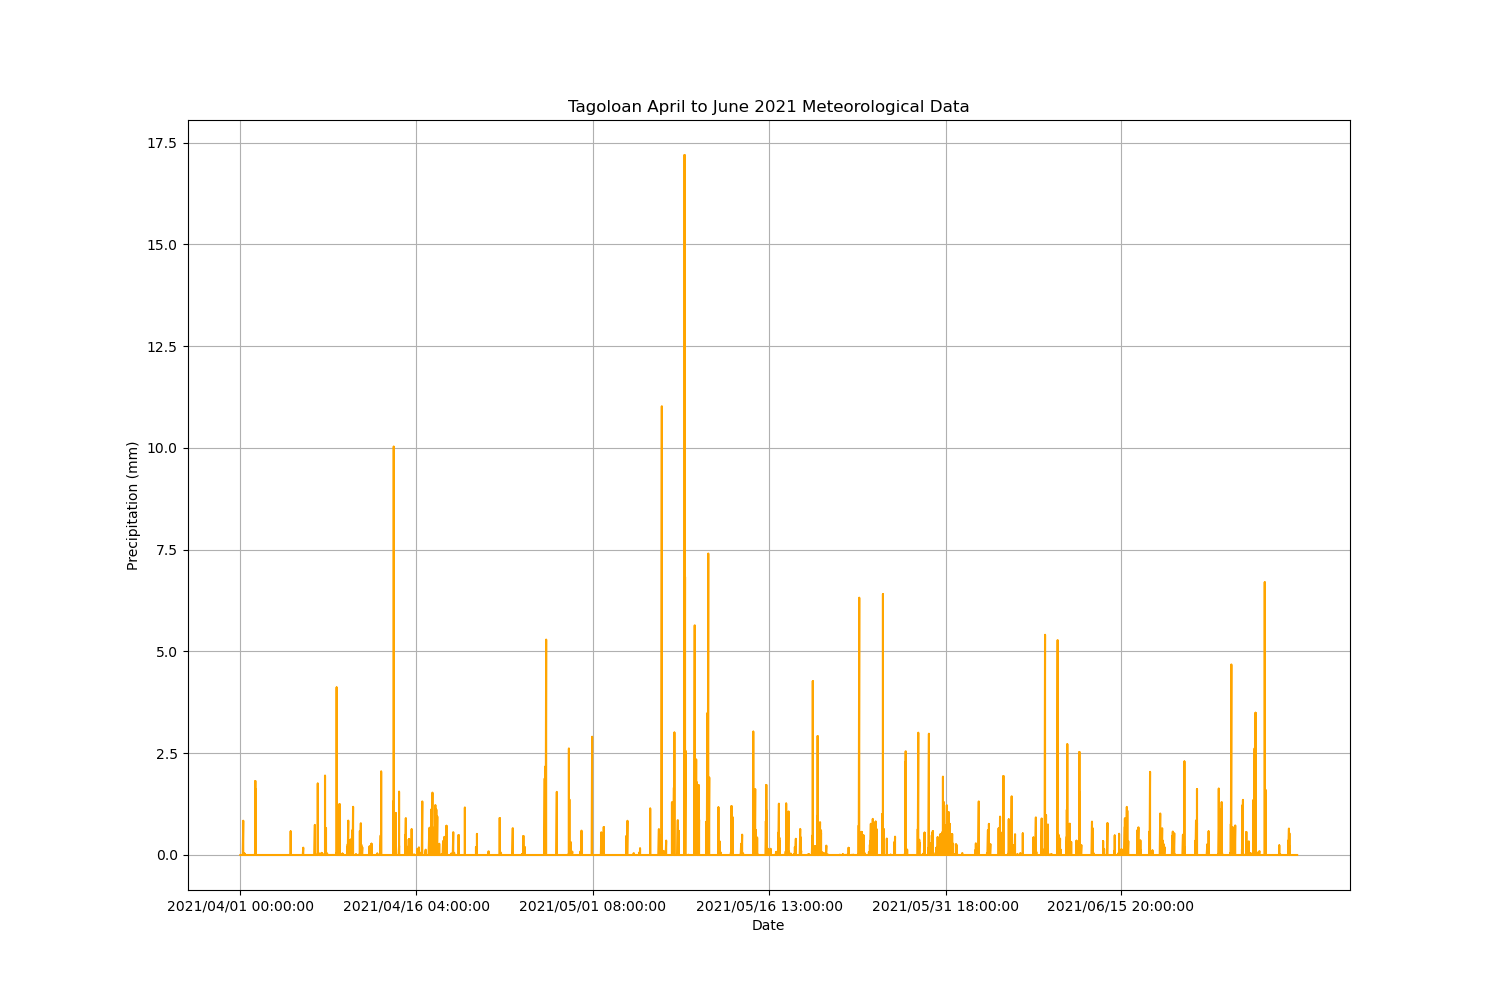

In [25]:


met_fig, ax = plt.subplots(figsize=[15,10])

ax.plot(timestamp,precipitation, color='orange')
ax.set_title(f"{river_name} {month} {year}Meteorological Data")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (mm)")

x_ticks_idx = np.linspace(0,len(timestamp), 7).round(0)
x_ticks = [i for idx, i in enumerate(timestamp) if int(idx) in x_ticks_idx]
ax.set_xticks(x_ticks)
ax.grid(True)

all_figs.append(met_fig)

plt.show()

Plot Water Level

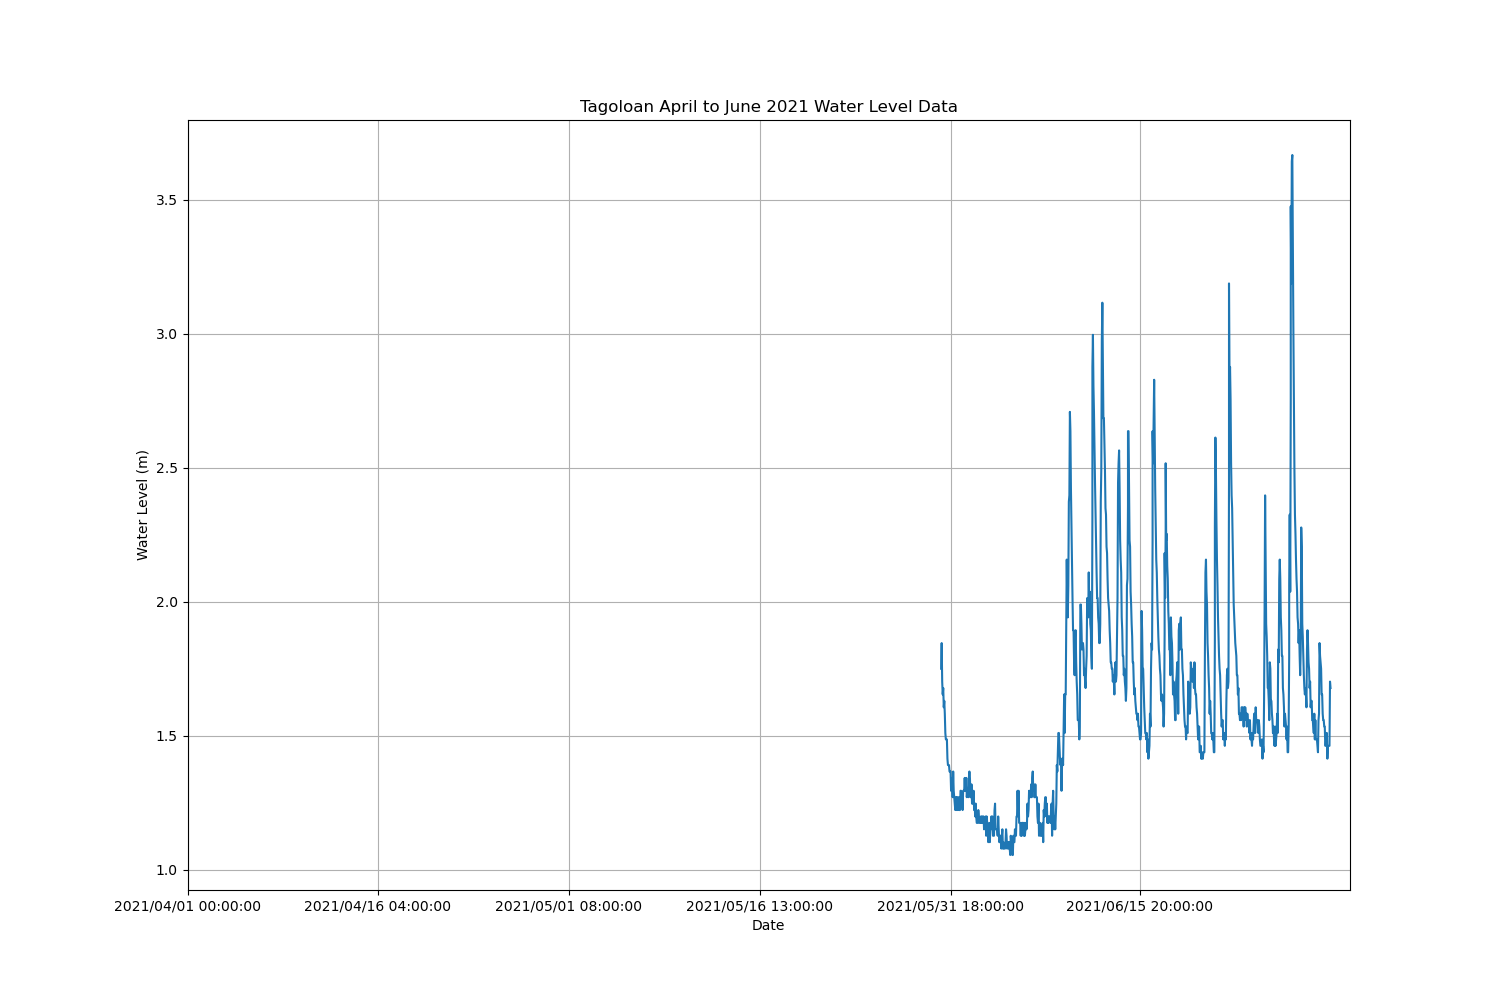

In [26]:
water_fig, ax = plt.subplots(figsize=[15,10])

ax.plot(timestamp,water_level, label="Water Level")

ax.set_title(f"{river_name} {month} {year}Water Level Data")
ax.set_xlabel("Date")
ax.set_ylabel("Water Level (m)")

x_ticks_idx = np.linspace(0,len(timestamp), 7).round(0)
x_ticks = [i for idx, i in enumerate(timestamp) if int(idx) in x_ticks_idx]
ax.set_xticks(x_ticks)

ax.grid(True)

all_figs.append(water_fig)

plt.show()

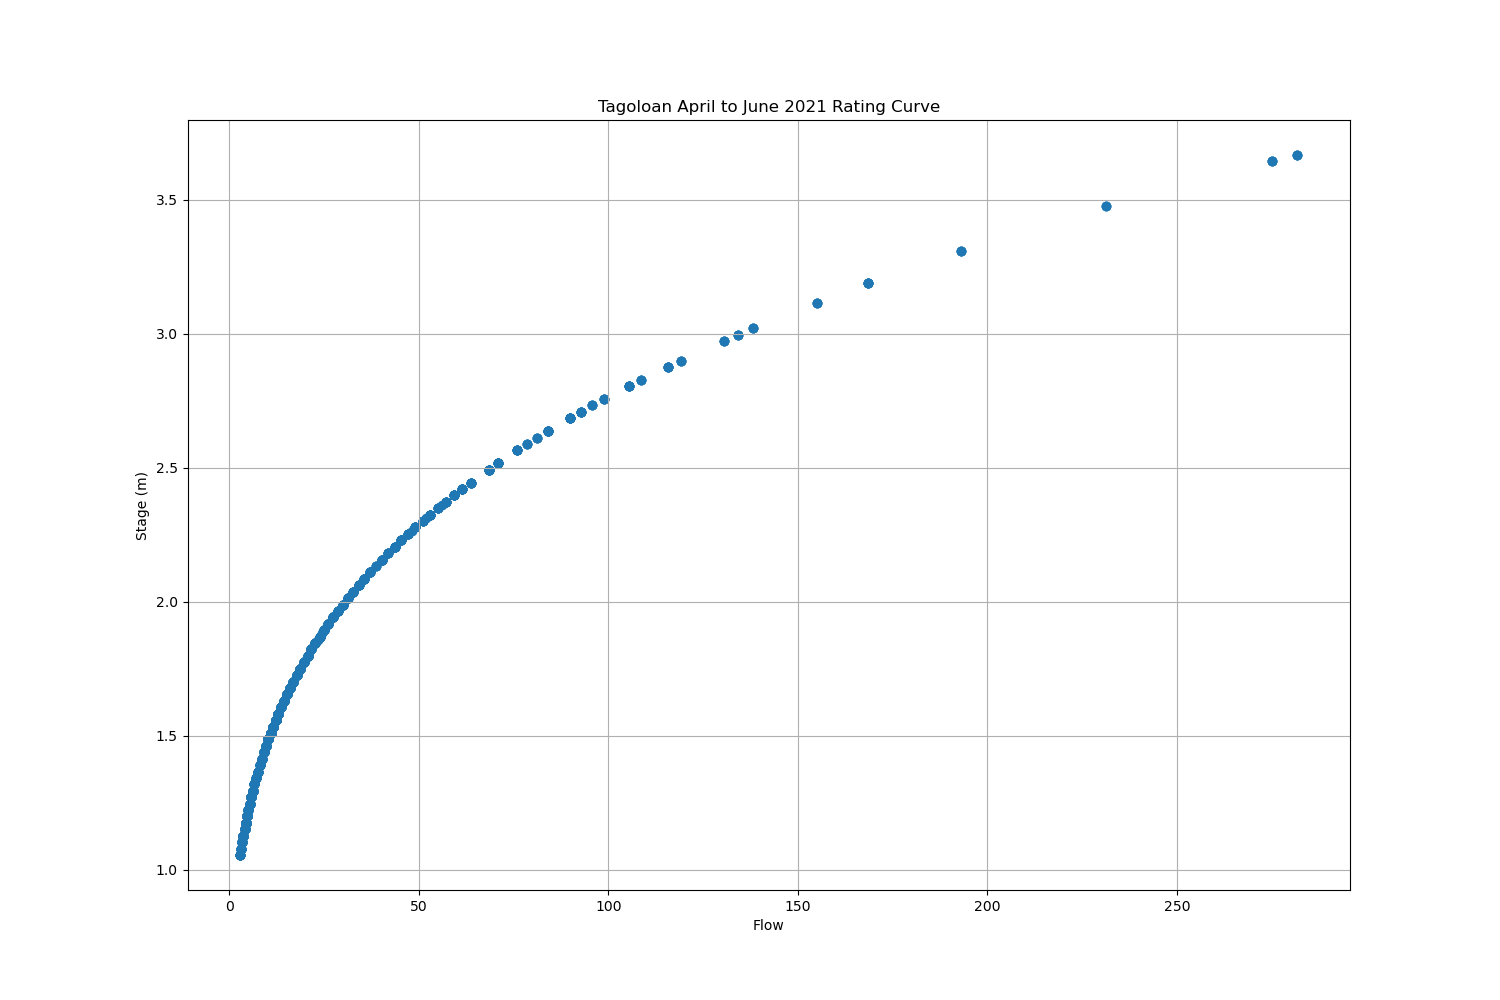

In [27]:
river_name = str(river).split('_')[-1]

rc_fig, ax = plt.subplots(figsize=[15,10])

ax.scatter(flow,water_level)
ax.set_title(f"{river_name} {month} {year}Rating Curve")
ax.set_xlabel("Flow")
ax.set_ylabel("Stage (m)")
ax.grid(True)

all_figs.append(rc_fig)
plt.show()

In [28]:
main_df.dropna()

,Timestamp,Corrected Water Level,Rain Gauge,Flow
5764,2021/05/31 00:00:00,1.749831,0.07262,18.704824
5765,2021/05/31 00:00:00,1.749831,0.00000,18.704824
5766,2021/05/31 00:00:00,1.749831,0.00000,18.704824
5767,2021/05/31 00:00:00,1.749831,0.00000,18.704824
5768,2021/05/31 01:00:00,1.845707,0.00000,22.743975
...,...,...,...,...
8751,2021/06/30 23:00:00,1.701893,0.00000,16.894136
8752,2021/07/01 00:00:00,1.677924,0.00000,16.038283
8753,2021/07/01 00:00:00,1.677924,0.00000,16.038283
8754,2021/07/01 00:00:00,1.677924,0.00000,16.038283


### Create Water Level and Precipitation Graph

ValueError: Axis limits cannot be NaN or Inf

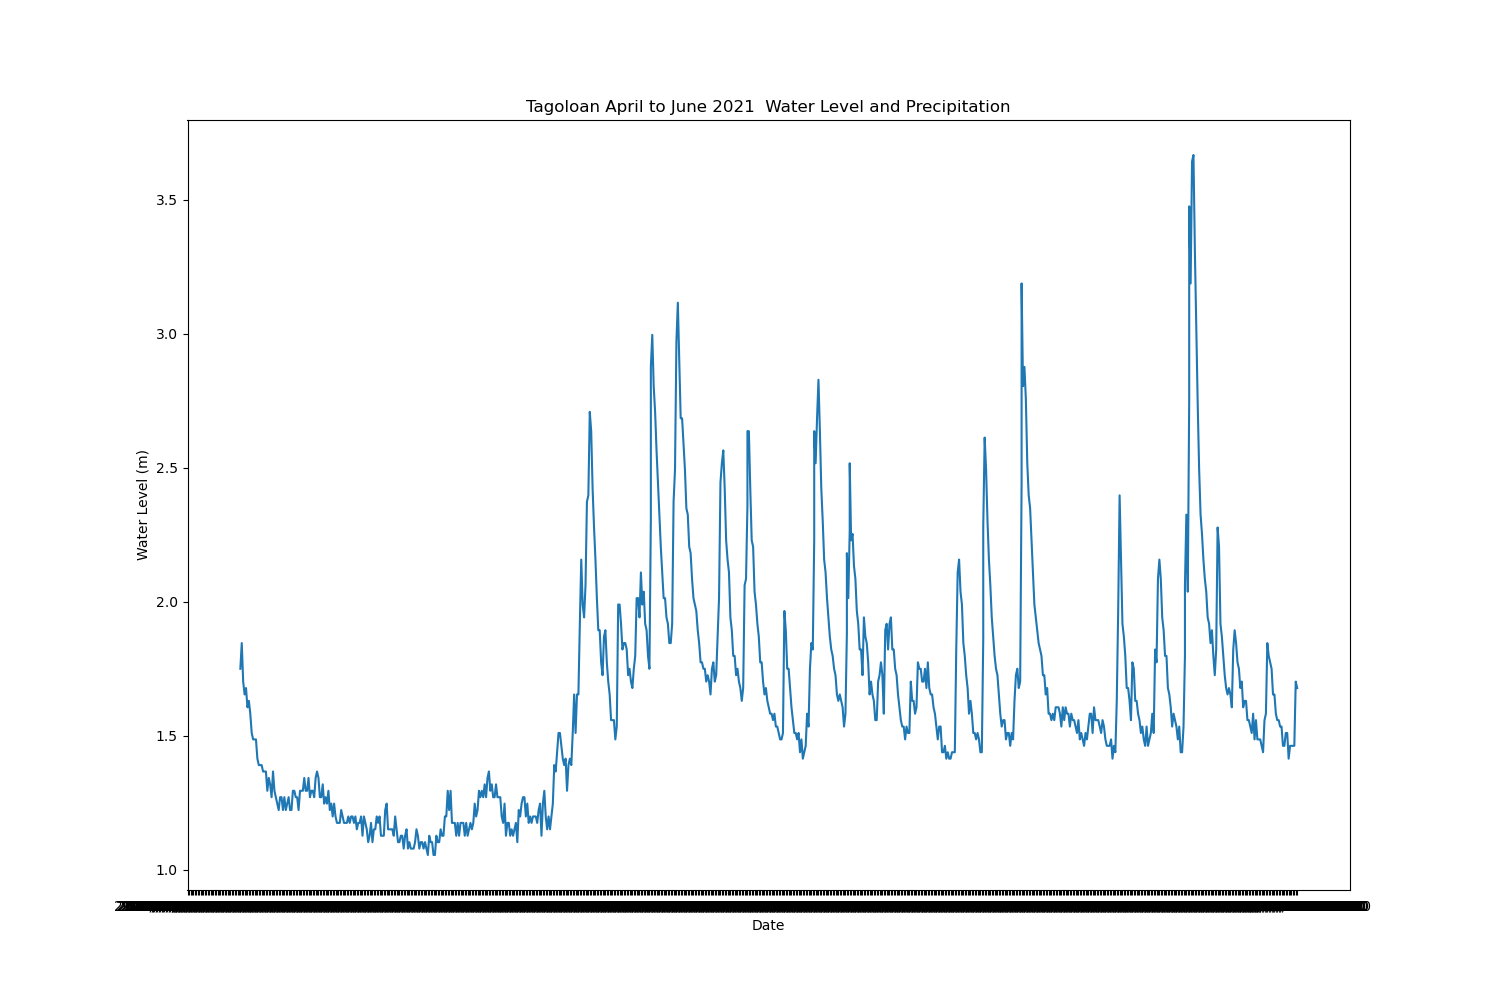

In [29]:
wlp_fig, ax = plt.subplots(figsize=[15,10])

ax.plot(timestamp,water_level, label="Water Level")

ax.set_title(f"{river_name} {month} {year} Water Level and Precipitation")
ax.set_xlabel("Date")
ax.set_ylabel("Water Level (m)")
ax.set_ylim((water_level.min()-0.5,water_level.max()*1.5))

ax2=ax.twinx()
ax2.plot(timestamp,precipitation, label="Precipitation", color='orange')
ax2.set_ylabel("precipitation in (mm)")
ax2.set_ylim((precipitation.min()-0.5,precipitation.max()*1.5))
ax2.invert_yaxis()

x_ticks_idx = np.linspace(0,len(timestamp), 7).round(0)
x_ticks = [i for idx, i in enumerate(timestamp) if int(idx) in x_ticks_idx]
ax.set_xticks(x_ticks)

ax.grid(True, axis='x')

wlp_fig.legend(loc="lower center", ncol=2)

all_figs.append(wlp_fig)

plt.show()

### Create Water Level and Precipitation Graph

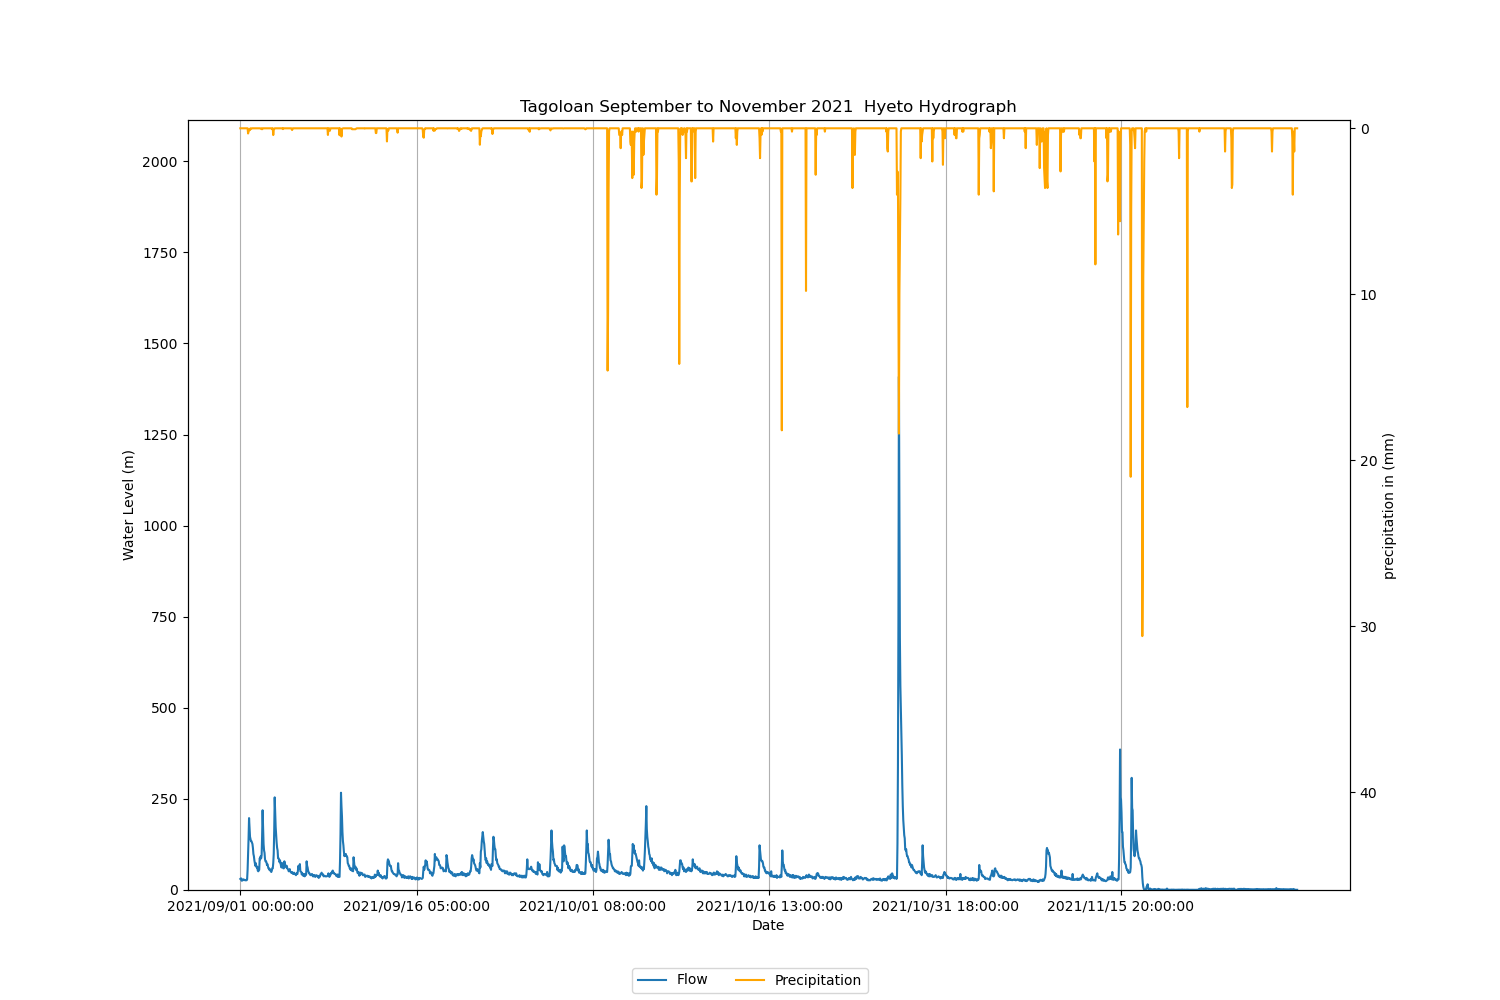

In [ ]:
hyeto_hydrograph_fig, ax = plt.subplots(figsize=[15,10])

ax.plot(timestamp,flow, label="Flow")

ax.set_title(f"{river_name} {month} {year} Hyeto Hydrograph")
ax.set_xlabel("Date")
ax.set_ylabel("Water Level (m)")
ax.set_ylim((flow.min()-0.5,flow.max()*1.5))

ax2=ax.twinx()
ax2.plot(timestamp,precipitation, label="Precipitation", color='orange')
ax2.set_ylabel("precipitation in (mm)")
ax2.set_ylim((precipitation.min()-0.5,precipitation.max()*1.5))
ax2.invert_yaxis()

x_ticks_idx = np.linspace(0,len(timestamp), 7).round(0)
x_ticks = [i for idx, i in enumerate(timestamp) if int(idx) in x_ticks_idx]
ax.set_xticks(x_ticks)

ax.grid(True, axis='x')

hyeto_hydrograph_fig.legend(loc="lower center", ncol=2)

all_figs.append(hyeto_hydrograph_fig)

plt.show()

# Optional multirating curve

In [ ]:
import matplotlib.colors as mcolors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
def multirating_curve(main_df,month, year):
    colors = list(mcolors.TABLEAU_COLORS.values())

    main_df['Month'] = main_df['Timestamp'].apply(lambda x: pd.to_datetime(x).month_name())

    last_2_months = main_df.iloc[-2:,-1].to_list()

    month_df = [i for _, i in main_df.groupby('Month') if i.Month.iloc[0] not in last_2_months]
    last_2_months_df = main_df.loc[main_df['Month'].isin(last_2_months)]

    month_df.append(last_2_months_df)

    def poly_reg_deg2(flow, water_level):
        flow = np.array(flow)
        water_level = np.array(water_level)
        
        blank_x = np.linspace(min(flow), max(flow)+1, int(len(flow)*10))

        poly = PolynomialFeatures(degree=2, include_bias=False)
        reg = LinearRegression()
        poly_features = poly.fit_transform(flow.reshape(-1,1))
        reg.fit(poly_features, water_level.reshape(-1,1))

        poly_features = poly.fit_transform(blank_x.reshape(-1,1))
        complete_y = reg.predict(poly_features)
        
        return blank_x, complete_y

    colors = list(mcolors.TABLEAU_COLORS.values())
    water_level_list = []
    flow_list = []
    months = []
    for df in month_df:
        df.reset_index(drop=True, inplace=True)
        water_level_list.append(df['Corrected Water Level'].to_numpy())
        flow_list.append(df['Flow'].to_numpy())
        month_name = df['Month'].iloc[0]
        months.append(month_name)

    mrc_fig, ax = plt.subplots(figsize=[15,10])
    count=0
    for water_level,flow, month_name in zip(water_level_list, flow_list, months):
        color = colors[count]
        ax.scatter(flow,water_level, label=month_name, color=color)
        count += 1

    ax.set_title(f"{river_name} {month} {year}Rating Curve")
    ax.set_xlabel("Flow (m^3)")
    ax.set_ylabel("Stage (m)")
    ax.grid(True)
    ax.legend()

    poly_mrc ,ax = plt.subplots(figsize=[15,10])
    count=0
    for water_level,flow, month_name in zip(water_level_list, flow_list, months):
        color = colors[count]
        x,y = poly_reg_deg2(flow, water_level)
        ax.plot(x,y, color=color, label=month_name)
        count+=1

    ax.set_title(f"{river_name} {month} {year} Polynomial Rating Curve")
    ax.set_xlabel("Flow (m^3)")
    ax.set_ylabel("Stage (m)")
    ax.grid(True)
    ax.legend()

    return mrc_fig, poly_mrc



Do you want to create a multirating curve for each month?

Wrong value, please try again
Do you want to create a multirating curve for each month?



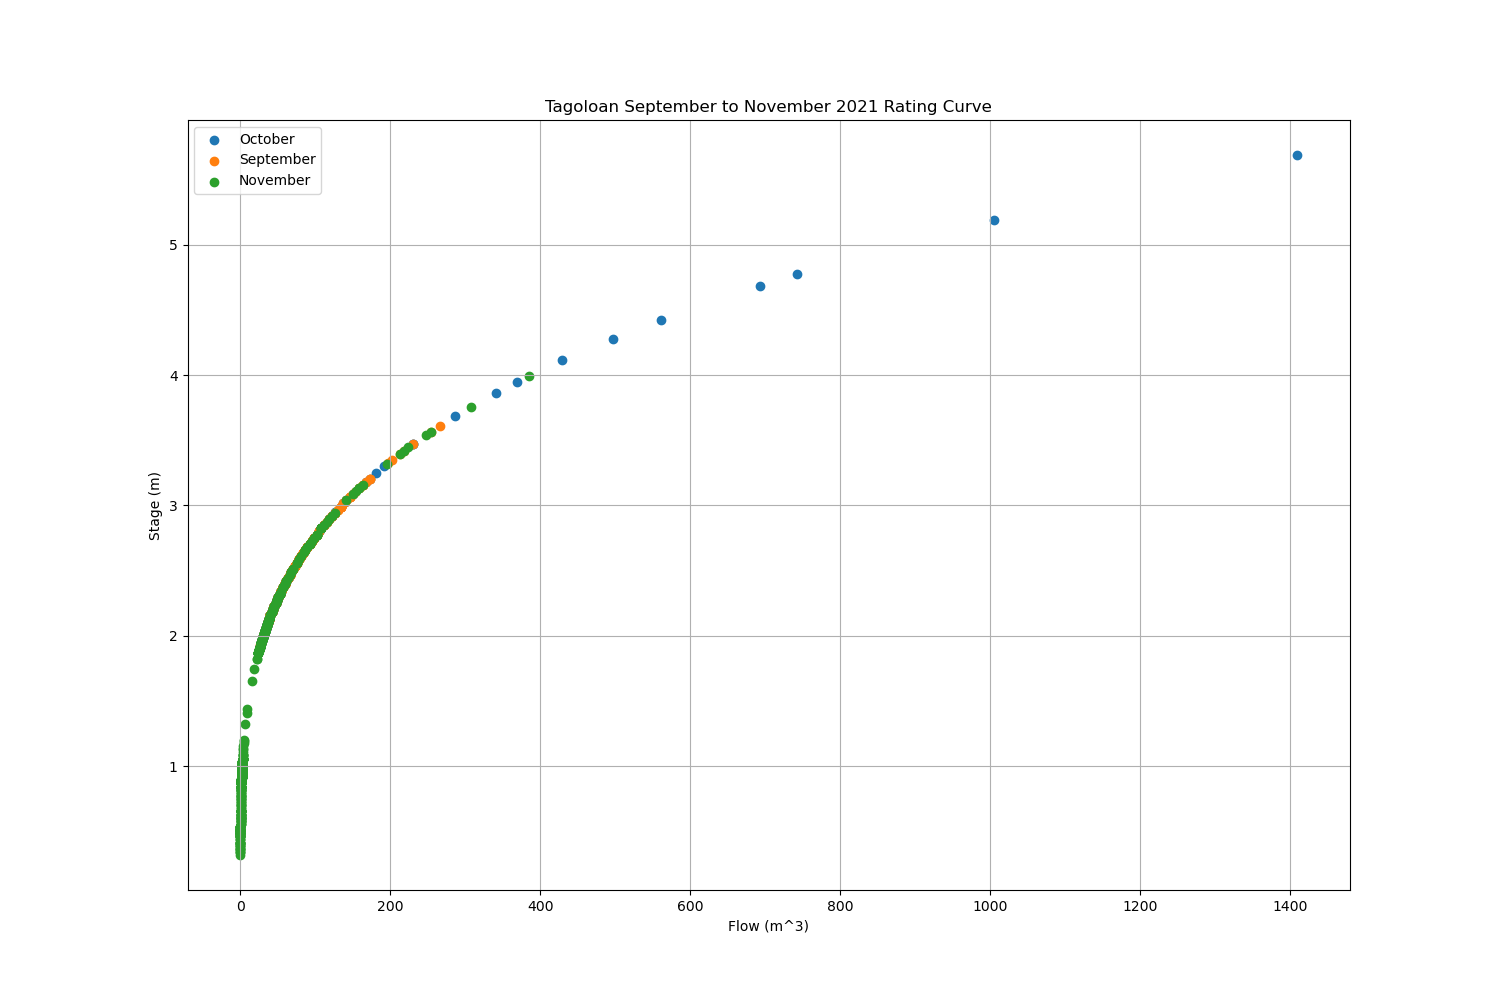

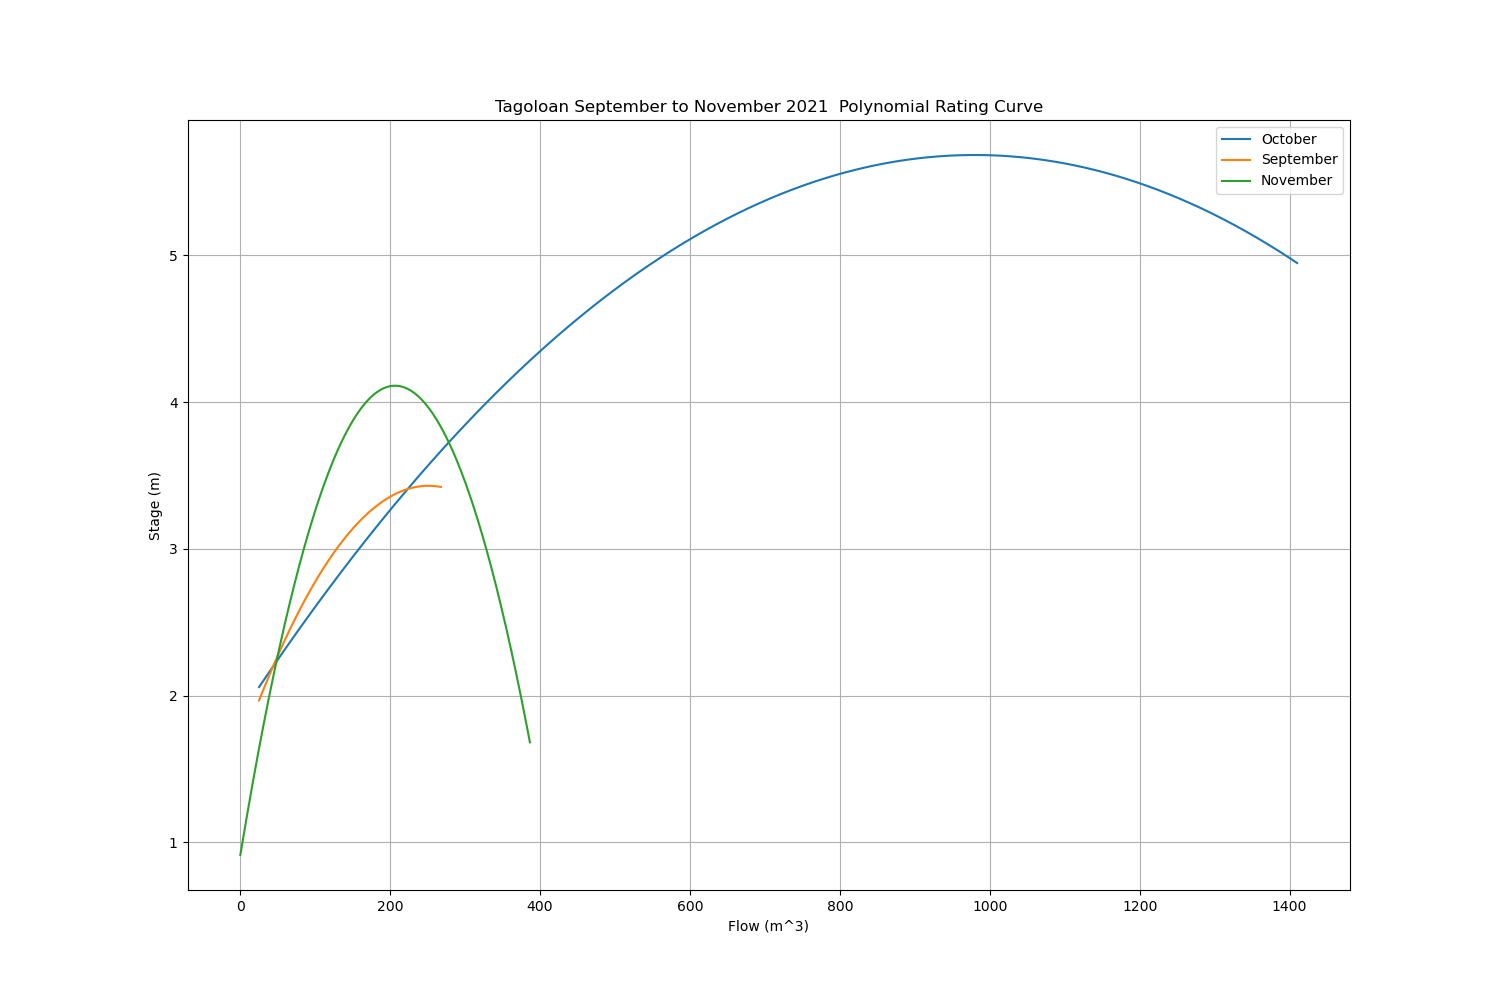

In [ ]:
while True:
    try:
        if no_of_files_condition == 2:
            print("Do you want to create a multirating curve for each month?\n")

            create_mrc = int(input("1 for yes, 0 for no."))

            if create_mrc == 1:
                mrc_fig, poly_mrc = multirating_curve(main_df, month, year)

                all_figs.append(mrc_fig)
                all_figs.append(poly_mrc)
            
            elif create_mrc == 0:
                print("Will not include multirating curve")
                break
        break
    except ValueError:
        print("Wrong value, please try again")
    

# Saving the Files

In [ ]:
from pathlib import Path
par_dir = Path("Hyeto-Hydrograph and Rating Curve Analysis Output")
filename = f"{river_name} {month} {year}"

pic_filenames = [f"{fig.axes[0].get_title()}.png" for fig in all_figs]
directory = os.path.join(par_dir, filename.strip())

try:
    os.mkdir(directory)
    print(f"Creating directory {directory}")
except:
    print("Appending to Existing Directory")

for fig, fname in zip(all_figs,pic_filenames):
    fig.savefig(os.path.join(directory,fname), dpi=600)

Creating directory Hyeto-Hydrograph and Rating Curve Analysis Output\Tagoloan September to November 2021


In [ ]:
def sort_per_col(df, lst):
    """Create and sort a new df per column and returns all the dfs and its corresponding name"""
    all_df = []
    df_names = []

    all_df.append(df.describe())
    df_names.append("Description")
    for col in lst:
        df1 = df.sort_values(col, ascending=False)
        df1_name = f"Sorted {col}"
        all_df.append(df1)
        df_names.append(df1_name)
    return df_names, all_df

df_names, all_df = sort_per_col(main_df, ['Corrected Water Level',"Rain Gauge","Flow"])
xl_directory = os.path.join(directory, filename.strip()+' Summative Excel.xlsx')
with pd.ExcelWriter(xl_directory) as writer:
    for fname, df in zip(df_names, all_df):
        df.to_excel(writer, sheet_name=fname)

print(f"All figures and the main report are saved to the {directory} folder")

All figures and the main report are saved to the Hyeto-Hydrograph and Rating Curve Analysis Output\Tagoloan September to November 2021 folder


In [ ]:
main_df.loc[main_df['Corrected Water Level'].isna()]

,Timestamp,Corrected Water Level,Rain Gauge,Flow
721,2021/05/01 00:00:00,NaN,0.00000,NaN
722,2021/05/01 00:00:00,NaN,0.00000,NaN
723,2021/05/01 00:00:00,NaN,0.00000,NaN
724,2021/05/01 00:00:00,NaN,0.00000,NaN
725,2021/05/01 01:00:00,NaN,0.00000,NaN
...,...,...,...,...
3596,2021/05/30 22:00:00,NaN,0.00000,NaN
3597,2021/05/30 23:00:00,NaN,0.00909,NaN
3598,2021/05/30 23:00:00,NaN,0.00000,NaN
3599,2021/05/30 23:00:00,NaN,0.00000,NaN
